## Predict the current Sale Price of a property in Mumbai

###### Motivation for this project

###### Challenges faced

* **Location** column that was collected through webscrapping was in the form of a string list. 1st I removed the square brackets and then seperated by , to convert to a list. Then I extracted location and society name and created 2 new columns. Also while scrapping if in the entry there was no mention of society name then for last param of location we are getting carpet area. This could be solved by only considering the 1st value as location for any records having carpet area or super area.


* **Floors** had nan values and I was not able to understand how to fill these values. I decided to drop these columns since we will be collecting data everyday and floor information is essential for the price.

* **Parking** This column seemed to have many anomalies and also had mentions of open and closed parking. So I created 2 columns, 1 for the number of parking spaces and the other for the type of parking and checked whether either no. of parking or type of parking had any impact on price. I found the number of parking spaces has a higher impact on price than type of parking only when the number of parking spaces is more than one. There is not much difference in house price when no. of parking is 0 or 1. I used the anova test here since I had bucketed parking into 3 categories which were both,covered and open parking.

* **Location conversion to latitude and longitude** This column according to my knowledge plays a significant role in the pricing of a property. Installing geppandas gave me some trouble however I was able to solve it by installing the library as administrator. I wanted to save whichever locations I have got the lat and long for since I did not want to call to geopy again and again for the same location. Latitude can be around 18 or 19 only and longitude around 72 or 73 degrees for Mumbai. Since not everyone puts generic location it becomes difficult to extract latitude and longitude. We are saving such records into a seperate file called bad records and not discarding it. This allows us to check whether such a bad column ever occurs again reducing execution time.

**These observations could change as we collect more data and it is esential for us to look into distributions and EDA everytime new data is added.**

### Modelling Inferences:

**Linear Regression**:

* The initial Linear Regression model was giving is a poultry r2_score of 52%.
* After performing the 5 tests of regresison we were able to get our score up to 73%. The main factor was performing log transform on the target variable that removed any heteroskedasticity present in the model. Although the model was still overfitting by about 6% (Difference between train and test r2_score).
* Next we performed regularization techniques and were able to reduce the test and train r2_score difference to less than 3%. Next we could try some non-linear tree based approaches that maybe able to better generalze our model.
------------------------------------------------------------------------------------------
**Tree Based Models**:


# Functions for plotting

In [1]:
def box_plot(x,y,data):
    import seaborn as sns
    plt.figure(figsize = (15,6))
    plt.title(x)
    sns.boxplot(x = x,y = y, data = data)
    plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.show()

In [2]:
def dis_plot(col,data):
    import seaborn as sns
    plt.figure(figsize = (15,6))
    sns.displot(data = data,x = col)
    plt.tight_layout()
    plt.show()

In [3]:
def scatter_plot(col,data):
    import numpy as np
    import matplotlib.pyplot as plt
    color = ['tab:purple','tab:green','tab:blue','tab:pink','tab:brown']
    plt.figure(figsize = (15,6))
    plt.scatter(x = col,y = 'price',data = data,c = color[np.random.randint(0,5)])
    plt.xlabel(col)
    plt.ylabel('price')
    plt.show()

# Feature Engineering

* Filling Missing values.
* Combining certain values in columns to help the machine better generalize.
* Creating new columns from existing columns like flat_type and BHK coming from the same column etc.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import scipy.stats as stats

In [5]:
#Location libraries
import geopy
from geopy.geocoders import Nominatim

In [6]:
if len(os.listdir('Data'))<=2:
    data = pd.read_csv('Data/scrapped.csv')
else:
    data = pd.read_csv('Data/'+os.listdir('Data')[-1])

In [7]:
#Drop any duplicate values
data.drop_duplicates(inplace = True)

In [8]:
data.shape

(2508, 17)

In [9]:
best_model = {}

## Handling the missing values

In [10]:
# (data.isna().sum()/len(data)*100)[(data.isna().sum()/len(data)*100)!=0]

In [11]:
#Drop the comments column
f_data = data.drop('comments',axis = 1)

In [12]:
f_data.head()

,Area_Type,Possession_Status,Floors,new_or_resale,furnishing,society,bathrooms,advertiser_name,bhk,price,parking,location,date_of_posting,facing,overlooking,area
0,carpet area,Possession by Dec '23,NaN,New Property,Unfurnished,Bachraj Lifespace,1.0,Bachraj Developers,1 BHK Apartment,₹ 34 Lac,NaN,"['Bachraj Lifespace,', 'Virar West']","Feb 04, '21",NaN,NaN,382 sqft
1,carpet area,Possession by Dec '23,NaN,New Property,Unfurnished,Bachraj Lifespace,1.0,Bachraj Developers,1 BHK Apartment,₹ 32 Lac,NaN,"['Bachraj Lifespace,', 'Virar West']","Feb 05, '21",NaN,NaN,348 sqft
2,super area,Ready to Move,2 out of 14 floors,New Property,Unfurnished,M Baria Everest,2.0,Ameya Builders & Property Developers,1 BHK Apartment,₹ 36 Lac,NaN,"['M Baria Everest,', 'Virar West']","Feb 05, '21",NaN,NaN,410 sqft
3,carpet area,Possession by Jun '21,NaN,New Property,Unfurnished,Joyville Virar,2.0,Shapoorji Pallonji,2 BHK Apartment,₹ 49.9 Lac,NaN,"['Joyville Virar,', 'Virar']","Feb 05, '21",NaN,NaN,759 sqft
4,super area,Possession by Jun '24,NaN,New Property,Semi-Furnished,NG Platinum City,2.0,RNA Builders NG,1 BHK Apartment,₹ 35.5 Lac,NaN,"['NG Platinum City,', 'Vasai East']","Feb 06, '21",NaN,NaN,374 sqft


In [13]:
#Handle the location column
def replace_area_loc(x,i):
    if x == 'carpet area' or x =='super area':
        return d['society'][i]
    else:
        return d['location'][i]
    

first_val = [i.strip('][').split(',')[0].strip("''") for i in data['location']]
second_val = [i.strip('][').split(',')[-1].strip(" '") for i in data['location']]

d = pd.DataFrame({'society':first_val,'location':second_val})
loc = []
for i in range(len(data['location'])):
    if replace_area_loc(d['location'][i],i).split()[0] == 'in':
        loc.append(replace_area_loc(d['location'][i],i)[3:])
        
    else:
        loc.append(replace_area_loc(d['location'][i],i))

f_data['location'] = loc #Saving

In [14]:
d.sample(5)

,society,location
913,Shree Ramdev Ritu Heights,Mira Road East
818,The Empress,Mira Road
447,Integrated Arya,in Ghatkopar West
1069,Aster Tower,Goregaon East
1709,Andheri West,carpet area


In [15]:
#drop society name since I do not consider it to be an important factor
f_data.drop('society',axis = 1,inplace = True)

In [16]:
f_data['furnishing'].value_counts()

Unfurnished       1328
Semi-Furnished     802
Furnished          374
Name: furnishing, dtype: int64

In [17]:
# (f_data.isna().sum()/len(f_data)*100)[(f_data.isna().sum()/len(data)*100)!=0]

In [18]:
#Furnishing is more likely to be unfurnished in my experience.
f_data['furnishing'].fillna(f_data['furnishing'].mode().values[0],inplace = True)

In [19]:
#From what I have observed on the site, usually when parking is not mentioned 
#it means that no parking is available with the listing. 
f_data['parking'].fillna('None',inplace = True)

In [20]:
#Getting number of rooms in the house
BHK = []
for i in f_data['bhk']:
    if len(i.split()[0].lower()) > 5:
        BHK.append('1')
    else:
        BHK.append(i.split()[0])
f_data['BHK'] = [int(i) for i in BHK]

In [21]:
#Config of room (Apartment,Flat,Penthouse,Builder Floor,Studio etc.)
config = []
for i in f_data['bhk']:
    if i.split()[0].lower() == 'studio':
        config.append('Studio')
    elif i.split()[-1].lower() == 'flat' or i.split()[-1].lower() == 'apartment':
        config.append('apartment') 
    elif i.split()[-1].lower() == 'penthouse':
        config.append(i.split()[-1]) 
    else:
        config.append('other')
f_data['config'] = config

In [22]:
# (f_data.isna().sum()/len(f_data)*100)[(f_data.isna().sum()/len(data)*100)!=0]

In [23]:
# imputation for bathroom feature
for i in f_data[f_data['bathrooms'].isna()].index:
    f_data['bathrooms'][i] = f_data['BHK'][i]

C:\Users\tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
#possession_status. Later we will be creating more columns using this column like
#construction or ready to move, possession pending and create possession date column as well.
f_data['Possession_Status'] = f_data['Possession_Status'].fillna('unavailable')

In [25]:
#floors
f_data = f_data.dropna(subset = ['Floors'])

In [26]:
#overlooking
f_data['overlooking'] = f_data['overlooking'].fillna(f_data['overlooking'].mode().values[0])

In [27]:
#facing
f_data['facing'] = f_data['facing'].fillna('None')

In [28]:
#overlooking can be converted to main road or other
f_data['overlooking'] = ['other' if i.lower() != 'main road' else 'main road' for i in f_data['overlooking']]

###### Missing values have now been filled. Now let us further perform imputations on our columns.

In [29]:
#Checking Sqft column
# First convert the sqft to a number by removing all non numeric figures and change dtype
# Check if super area or carpet area. 
# If super area then change to carpet area. 
# Carpet area is 70% of super area according to magicbricks.
l = []
for i in f_data['area']:
    try:
        l.append(int(i[:-4].strip()))
    except:
        l.append(np.nan)
f_data['area'] = l

In [30]:
# Drop records having nan in area
f_data = f_data.dropna(subset = ['area'])

###### All missing values have now been handled

In [31]:
#Drop the OG bhk,advertiser_name, column
f_data = f_data.drop(['bhk','advertiser_name'],axis=1)
f_data = f_data.reset_index(drop = True)

In [32]:
#Converting super area to carpet
for i in range(len(f_data)):
    if f_data['Area_Type'][i] == 'super area':
        f_data['area'][i] = round(0.7*f_data['area'][i])
    else:
        pass
f_data = f_data.drop('Area_Type',axis = 1)

C:\Users\tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [33]:
#Convert Possession_Status to received and not received
f_data['Possession_Status'] = ['received' if i.lower() == 'ready to move' else 'not received' for i in f_data['Possession_Status']]

In [34]:
#Floors Create 2 columns flat_floor_no.,total_floors
f_data['flat_floor_no.'] = f_data['Floors'].apply(lambda x: x.split()[0])

total_floors = []
for i in f_data['Floors']:
    try:
        total_floors.append(i.split()[-2])
    except:
        total_floors.append(np.nan)
f_data['total_floors'] = total_floors
f_data = f_data.drop('Floors',axis = 1).dropna(subset = ['total_floors'])

In [35]:
#price. We will have to bring lacs and crores into one scale. So we will convert lac to crore.
true_price = []
for i in f_data['price']:
    if i.split()[-1].lower() == 'lac':
        true_price.append(round(float(i.split()[1])*0.01,2))
    else:
        true_price.append(float(i.split()[1]))
f_data['price'] = true_price

In [36]:
#1. Create a column for parking available
first_extract_parking = [0 if len(i.split())==1 else int(i.split()[0]) for i in f_data['parking']]
final_extract_parking = [i if i<10 else 1 for i in first_extract_parking]
f_data['no_of_parking'] = final_extract_parking

In [37]:
#2. Create a column as open,closed,both,none
def parking_imputer(x):
    if len(x.split())>2:
        return 'both'
    elif len(x.split())==2:
        return x.split()[1]
    else:
        return 'Open'

    
f_data['parking_type'] = f_data['parking'].apply(parking_imputer)

In [38]:
#Drop Parking column
f_data = f_data.drop(['parking'],axis = 1)
f_data = f_data.reset_index(drop = True)

In [39]:
#Date column can be dropped at the time of modelling since date_of_posting has no relation with property price.
#Hoever it can be used for analysis and to check modelling, trend and seasonality once we have an entire years data.

###### Handling the data types for each column

In [40]:
#Converting total_floors from object to integer
f_data['total_floors'] = f_data['total_floors'].astype("int64")

In [41]:
#Checking flat_floor_no to see what anomalies are present.
f_data['flat_floor_no.'].unique()

array(['2', '1', '9', '4', '5', '8', '15', '11', '6', '10', '20', '22',
       'Lower', '12', '3', '7', '18', '16', '26', '17', '23', 'Ground',
       '14', 'Upper', '31', '13', '19', '41', '28', '45', '33', '30',
       '24', '35', '36', '27', '25', '42', '37', '39', '21', '32', '50',
       '46', '29', '34', '44', '40', '59', '48', '38'], dtype=object)

In [42]:
def flat_flr_no_impute(x):
    if x.lower().strip()=='ground':
        return 1
    else:
        return x
f_data['flat_floor_no.'] = f_data['flat_floor_no.'].apply(flat_flr_no_impute)

In [43]:
#Convert Ground to 1, 'Lower' to 0.2*total_floors, and 'Upper' as 0.7*total_floors

#For lower and upper exact floor number is not given. We can take 20% of total floors for lower, and 70% of total floors for upper
for i in range(len(f_data)):
    if f_data['flat_floor_no.'][i] == 'Lower':
        f_data['flat_floor_no.'][i] = round(f_data['total_floors'][i]*0.2)
    elif f_data['flat_floor_no.'][i] == 'Upper':
        f_data['flat_floor_no.'][i] = round(f_data['total_floors'][i]*0.7)
    else:
        pass
f_data['flat_floor_no.'] = f_data['flat_floor_no.'].astype("int64")

C:\Users\tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [44]:
#Create a dictionary that would contain the location data so that we dont have to call geopy again and again
def location_convert(base_location,loc_path,loc_col):
    import pandas as pd
    bad_l = pd.read_csv('locations/Bad locations/latest_bad_loc.csv')['location'].unique()
    try:
        import json
        #If directory not present
        if 'location.json' not in os.listdir('locations'):
            open(loc_path,mode = 'w')
        else:
            pass

        
        locator = Nominatim(user_agent="myGeocoder") #Assigning the user agent or API for the locations
        base_location = base_location+',' #Adding comma so that we get Mumbai,Andheri East for example.
        
        with open(loc_path) as loc_input: 
            location_dict = json.load(loc_input) #Loading the json file from directory.

        error_vals = [] #For the values in this list, geopy failed to load latitude and longitude data.
        
    #Looping over all values in dataset and if not present in location_dict then using geopy to get lat and long
        for i in loc_col:
            try:
                if i not in location_dict.keys():
                    if i not in bad_l:
                        locating = locator.geocode(base_location+i)
                        location_dict.setdefault(i,(locating.latitude,locating.longitude))
                else:
                    pass
            except Exception as e:
                print(e)
                error_vals.append(i)


        #Saving dictionary as a local json   
        json.dumps(location_dict) #To create a json file of our dictionary.
        with open(loc_path,mode='w') as output:
            json.dump(location_dict,output)
        return location_dict,error_vals
    except:
        print("The location is not receiving any geocode from geopy. Check location value")

In [45]:
location_dict,error_vals = location_convert(base_location = 'Mumbai',loc_path = r'locations/location.json',loc_col = f_data['location'].unique())

In [46]:
#Getting latitude and longitude from dictionary
def mapping_latitude(x):
    try:
        return location_dict[x][0]
    except:
        return np.nan
    
def mapping_longitude(x):
    import numpy as np
    try:
        return location_dict[x][1]
    except:
        return np.nan
    
f_data['longitude'] = f_data['location'].apply(mapping_longitude) #Mapping longitude values to new column
f_data['latitude'] = f_data['location'].apply(mapping_latitude)   #Mapping latitude values to new column

In [47]:
#Create a csv file for all records that were not mapped as bad records
bad_data = f_data[((f_data['longitude'].isna()) | (f_data['latitude'].isna()) | (f_data['longitude']<0) | (f_data['latitude']<0)| (f_data['longitude']>75) | (f_data['latitude']<18))]
if len(os.listdir('Locations/Bad locations'))==0:
    bad_data.to_csv('Locations/Bad locations/badloc.csv',index = False)
else:
    og_bad = pd.read_csv('Locations/Bad locations/badloc.csv')
    pd.concat((bad_data,og_bad)).to_csv('Locations/Bad locations/latest_bad_loc.csv',index = False)

In [48]:
f_data = f_data[~((f_data['longitude'].isna()) | (f_data['latitude'].isna()) | (f_data['longitude']<0) | (f_data['latitude']<0) | (f_data['longitude']>75) | (f_data['latitude']<18) )]

In [49]:
f_data['location'].value_counts().head(5)

Mulund West      68
Goregaon East    56
Chembur          54
Virar West       53
Andheri West     47
Name: location, dtype: int64

In [50]:
#Dropping the location column since it latitude and longitude will work for machine and also dropping any nan values.
f_data = f_data.drop('location',axis = 1).dropna()

# Exploratory Data Analysis for feature manipulation

### Univariate Analysis

In [51]:
f_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885 entries, 0 to 2309
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Possession_Status  1885 non-null   object 
 1   new_or_resale      1885 non-null   object 
 2   furnishing         1885 non-null   object 
 3   bathrooms          1885 non-null   float64
 4   price              1885 non-null   float64
 5   date_of_posting    1885 non-null   object 
 6   facing             1885 non-null   object 
 7   overlooking        1885 non-null   object 
 8   area               1885 non-null   float64
 9   BHK                1885 non-null   int64  
 10  config             1885 non-null   object 
 11  flat_floor_no.     1885 non-null   int64  
 12  total_floors       1885 non-null   int64  
 13  no_of_parking      1885 non-null   int64  
 14  parking_type       1885 non-null   object 
 15  longitude          1885 non-null   float64
 16  latitude           1885 

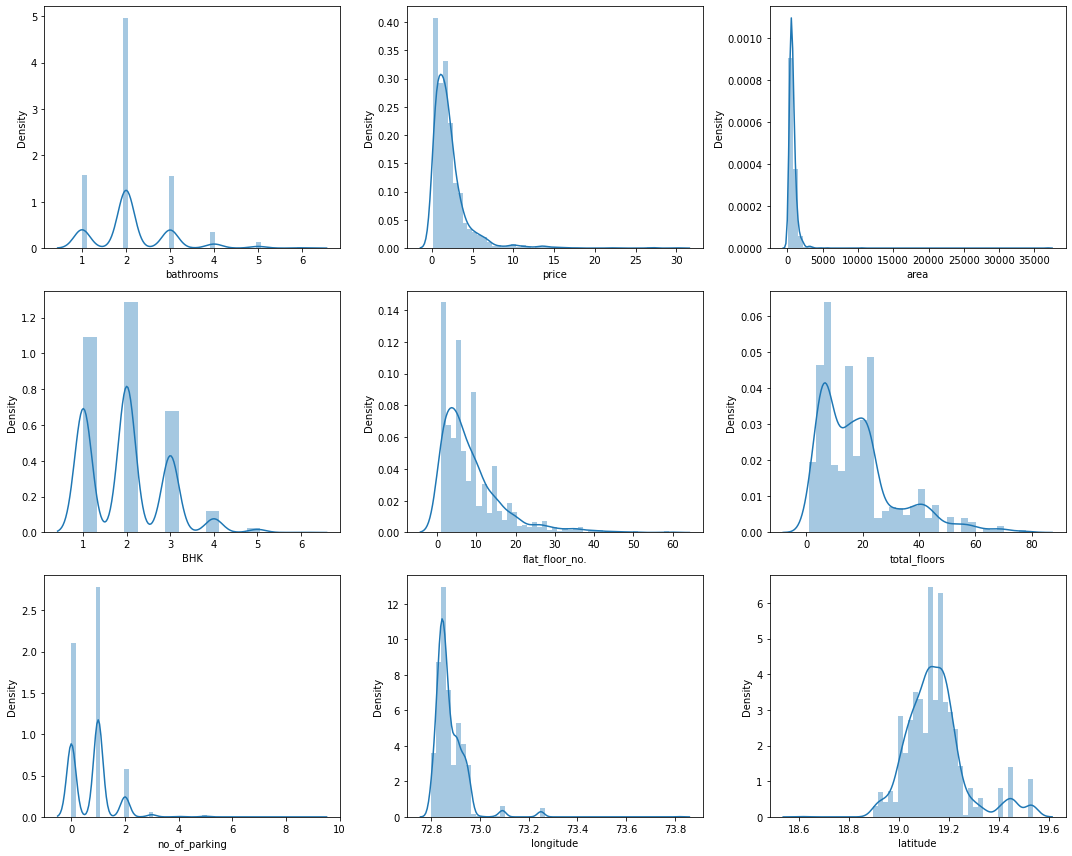

In [52]:
#Plotting distributions
import warnings
warnings.simplefilter('ignore')
fig,ax = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for variables,plotsubs in zip(f_data.select_dtypes(np.number).columns,ax.flatten()):
    sns.distplot(a = f_data[variables],ax = plotsubs)
    plt.tight_layout()
plt.show()
#A lot of our numerical columns are psitively skewed. We could apply log or boxcox transformation on these columns.

In [53]:
#Log transformation seems to be a good option for area,flat_floor_no.,total_floors.
f_data['area_log'] = np.log(f_data['area'])
f_data['flat_floor_no_log'] = np.log(f_data['flat_floor_no.'])
f_data['total_floors_log'] = np.log(f_data['total_floors'])

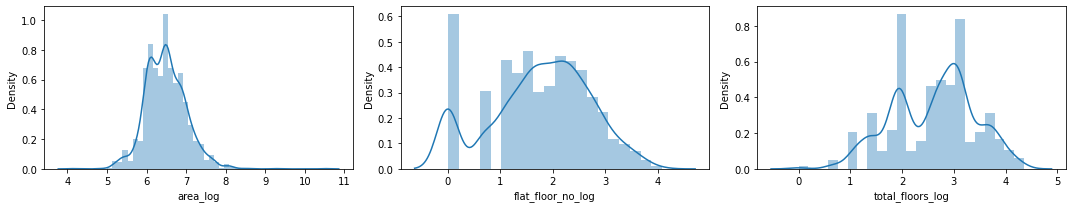

In [54]:
import warnings
warnings.simplefilter('ignore')
fig,ax = plt.subplots(nrows = 1,ncols = 3,figsize = (15,3))
for variables,plotsubs in zip(f_data.select_dtypes(np.number)[['area_log','flat_floor_no_log','total_floors_log']].columns,ax.flatten()):
    sns.distplot(a = f_data[variables],ax = plotsubs)
    plt.tight_layout()
plt.show()
#Now we can see that all our skewed variables are now showing a more normal distribution.

In [55]:
f_data.columns

Index(['Possession_Status', 'new_or_resale', 'furnishing', 'bathrooms',
       'price', 'date_of_posting', 'facing', 'overlooking', 'area', 'BHK',
       'config', 'flat_floor_no.', 'total_floors', 'no_of_parking',
       'parking_type', 'longitude', 'latitude', 'area_log',
       'flat_floor_no_log', 'total_floors_log'],
      dtype='object')

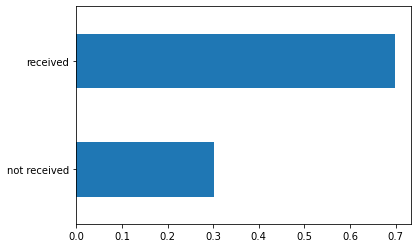

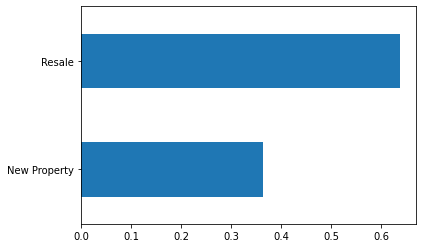

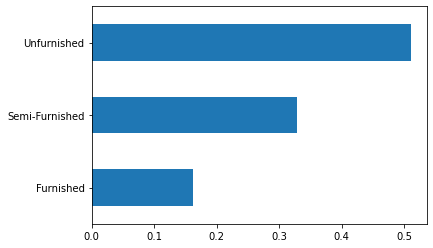

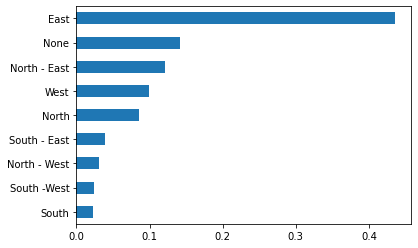

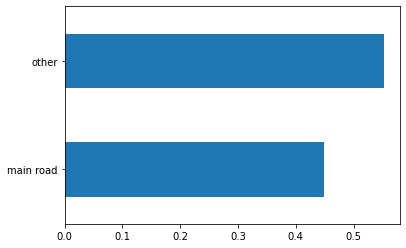

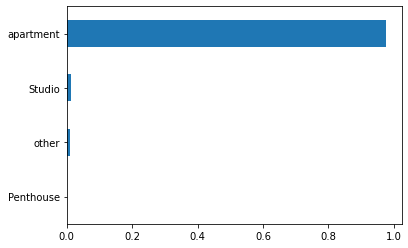

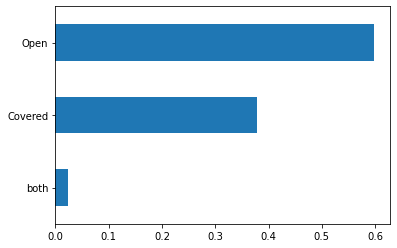

In [56]:
#Univariate analysis of categorical variables.
for i in f_data[['Possession_Status', 'new_or_resale', 'furnishing','facing', 'overlooking','config','parking_type']].columns:
    f_data[i].value_counts(normalize = True).sort_values().plot(kind = 'barh')
    plt.show()

###### Once data for entire year is collected we can use the date posted column as well to check trends in the market.

###### Inferences from first collection of data
* There are more properties listed on magicbricks that have received possession than properties that have not.
* More resale properties are available on the market compared to newer projects.
* More houses are east facing which is known to be good auspiciously. This is an India specific sentiment.
* There as many property that face the main road as property that don't face the main road.
* There are more properties having open parking than covered parking.
* Price is almost always skewed in any dataset that we see. The same is true even in this webscrapped dataset.

### Bivariate Analysis

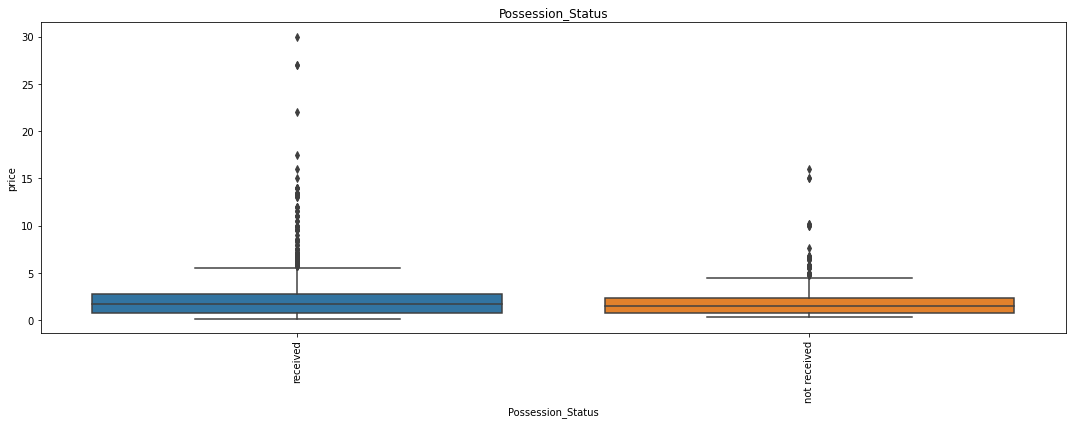

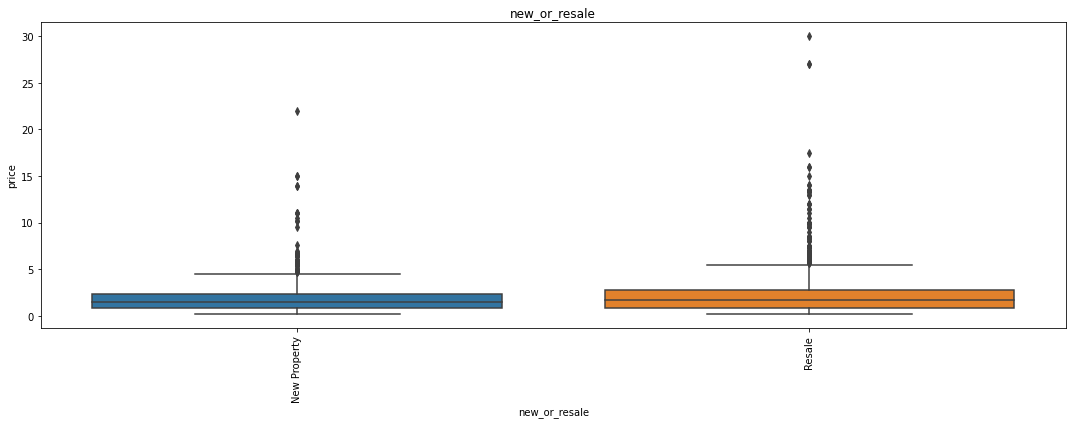

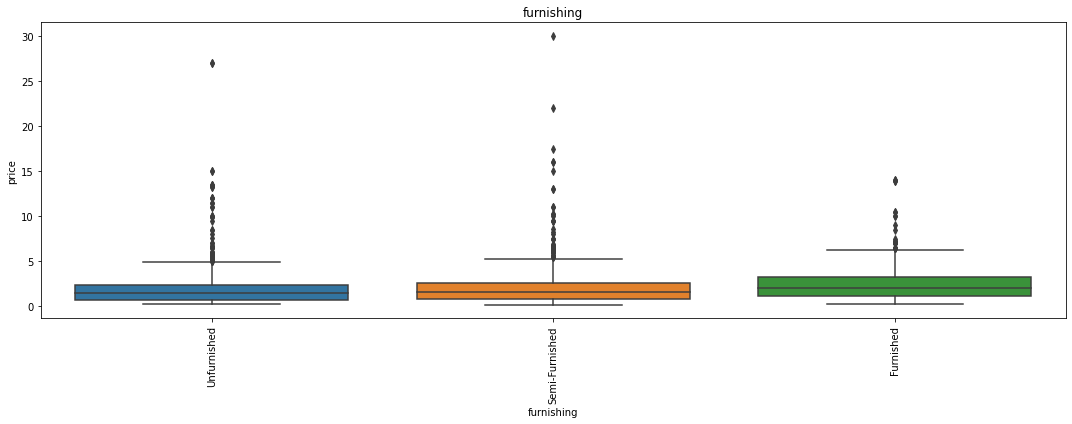

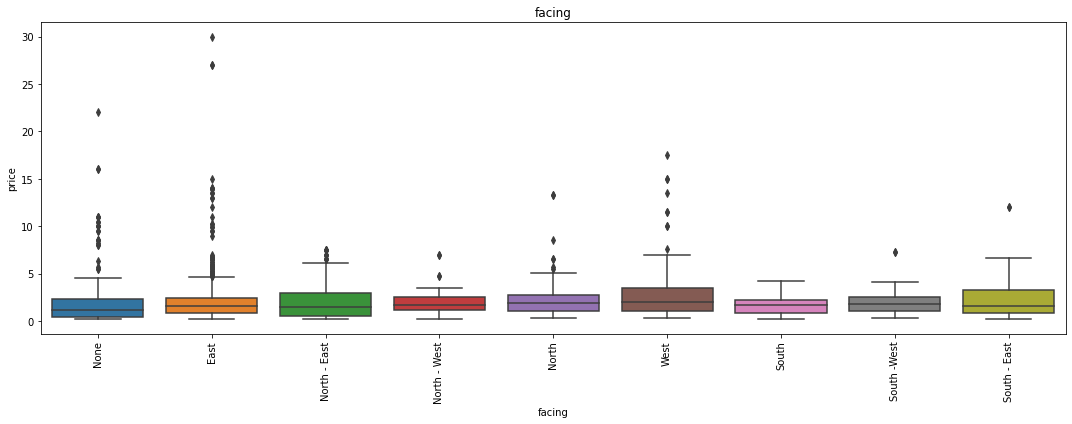

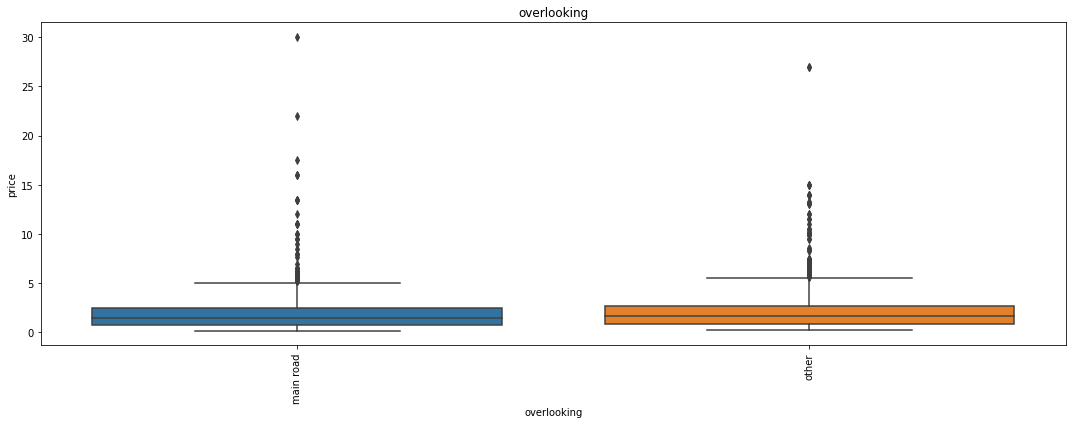

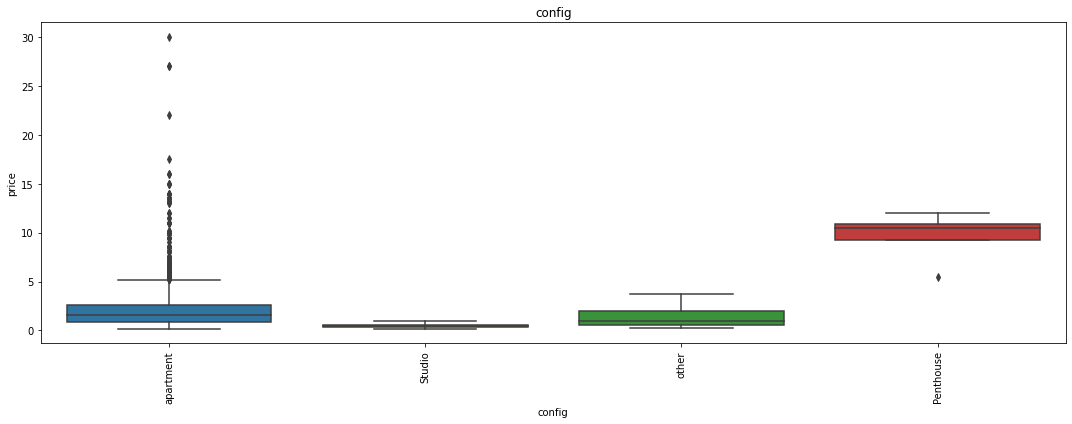

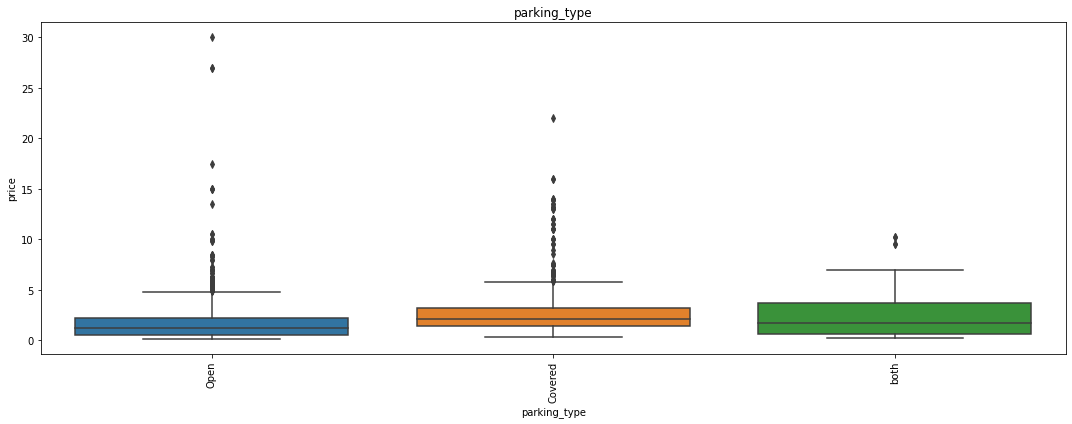

In [57]:
#Plotting box plots for all categorical columns
for i in f_data[['Possession_Status', 'new_or_resale', 'furnishing','facing', 'overlooking','config','parking_type']].columns:
    box_plot(i,'price',data = f_data)
#There area some categorical features that do have subtle differences in price. 
#For example furnished flats tend to be more expensive than unfurnished.
#Resale is tending to fetch slightly more price compared to new property.
#Receiving possession is also driving the price up.
#Properties proving covered parking tend to be more expensive.

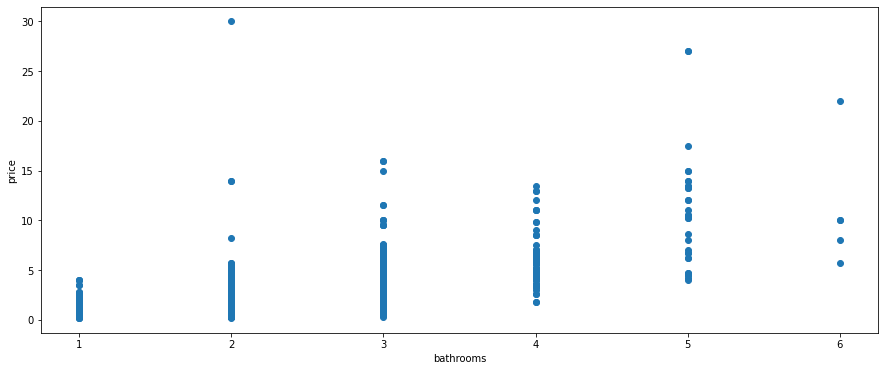

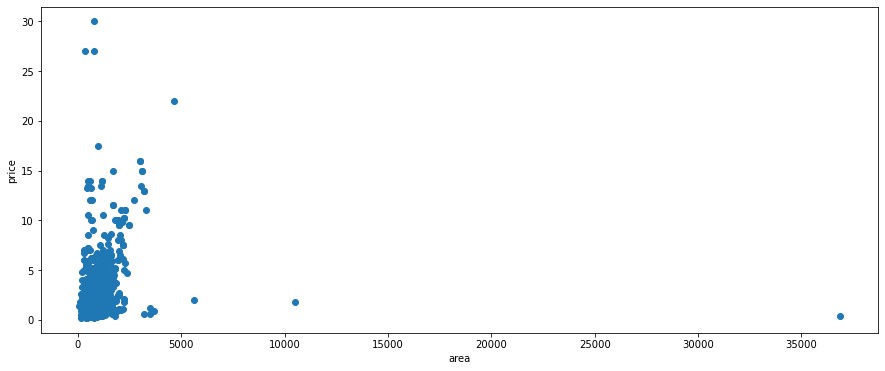

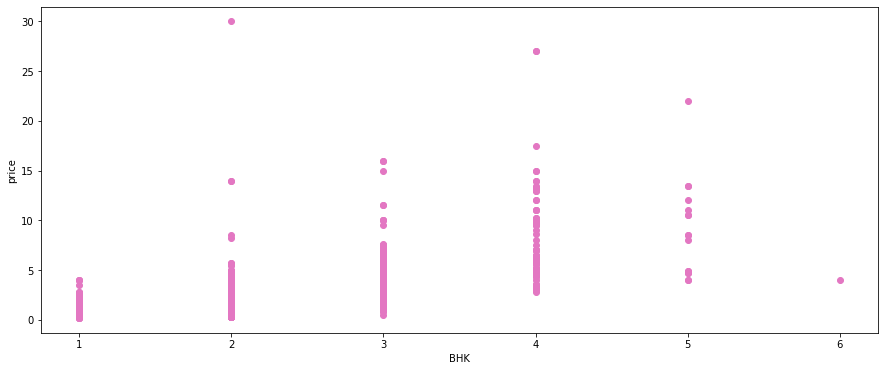

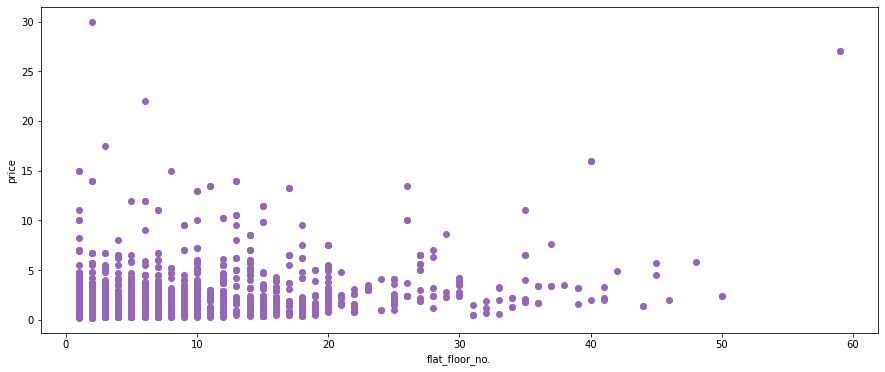

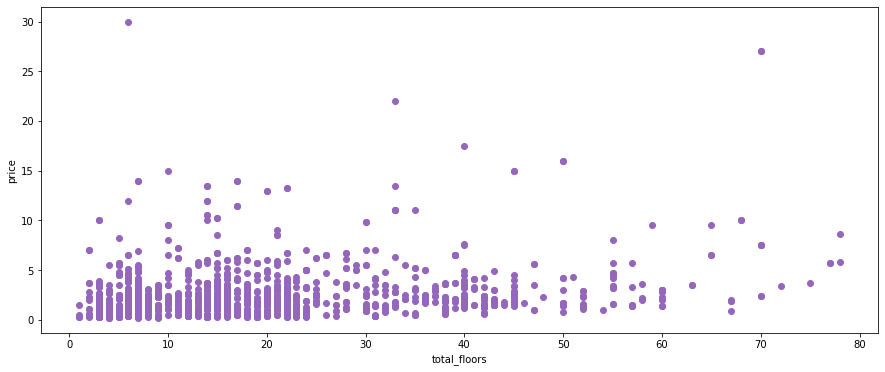

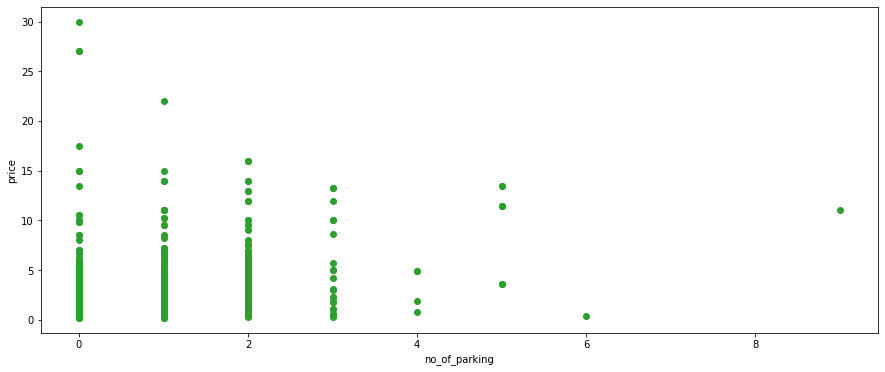

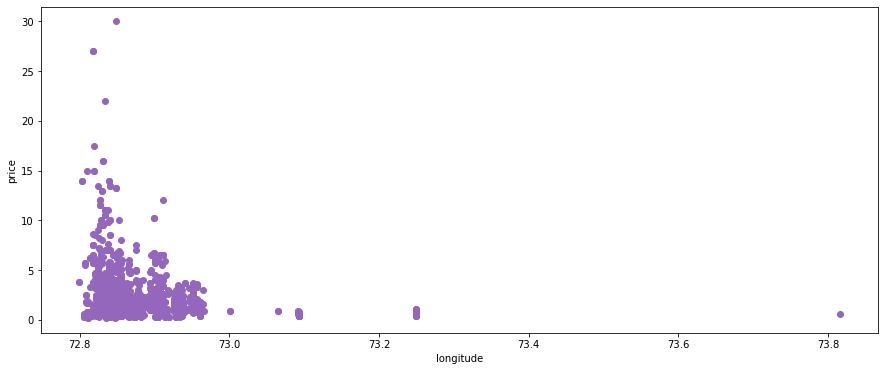

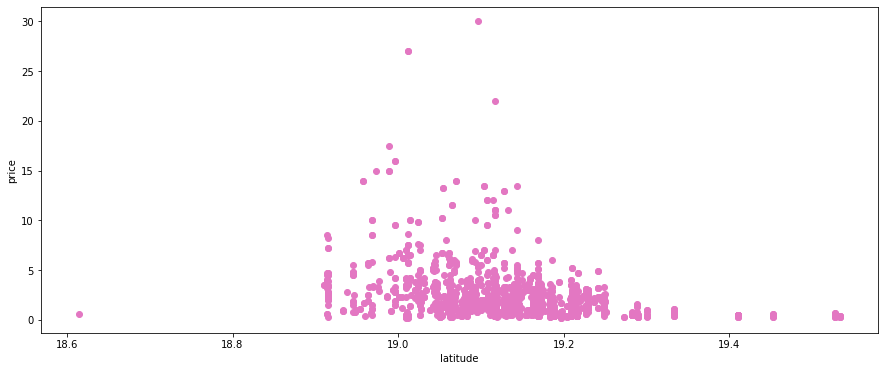

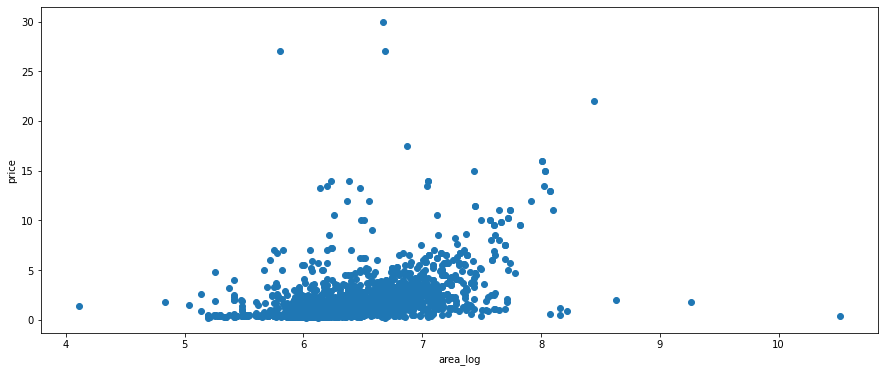

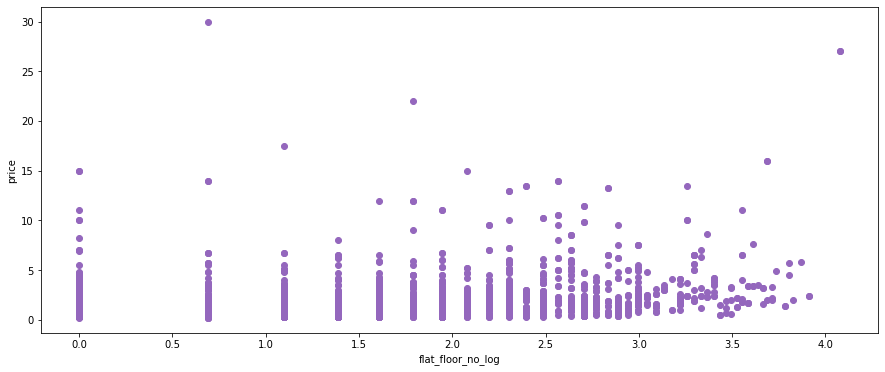

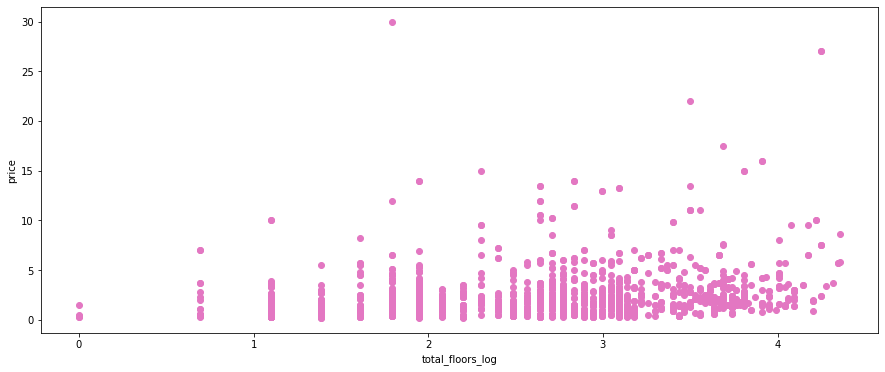

In [58]:
for i in f_data.select_dtypes(np.number).drop('price',axis = 1).columns:
    scatter_plot(i,f_data)

In [59]:
#We could change the facing column to good and bad but as input we would keep directions as options. 
#We would make the imputations at the backend as good and bad.
#according to Vastu, the East, North and Northeast are considered good and the rest are not that great.
gorb = ['Unknown','Good','Bad','Good','Good','Good','Bad','Bad','Bad']
f_data['facing'].unique()
facing_mapper = dict(zip(f_data['facing'].unique(),gorb))

f_data['Vastu_direction'] = f_data['facing'].map(facing_mapper)

In [60]:
#Dropping area,flat_floor_no,total_floors
f_data = f_data.drop(['area','flat_floor_no.','total_floors'],axis = 1)

In [61]:
#Dropping date of posting
f_data = f_data.drop('date_of_posting',axis  = 1)

In [62]:
#Dropping the facing column since I have generalized it as can be seen above.
f_data = f_data.drop('facing',axis = 1)

In [63]:
f_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885 entries, 0 to 2309
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Possession_Status  1885 non-null   object 
 1   new_or_resale      1885 non-null   object 
 2   furnishing         1885 non-null   object 
 3   bathrooms          1885 non-null   float64
 4   price              1885 non-null   float64
 5   overlooking        1885 non-null   object 
 6   BHK                1885 non-null   int64  
 7   config             1885 non-null   object 
 8   no_of_parking      1885 non-null   int64  
 9   parking_type       1885 non-null   object 
 10  longitude          1885 non-null   float64
 11  latitude           1885 non-null   float64
 12  area_log           1885 non-null   float64
 13  flat_floor_no_log  1885 non-null   float64
 14  total_floors_log   1885 non-null   float64
 15  Vastu_direction    1885 non-null   object 
dtypes: float64(7), int64(2),

### Statistical Analysis

###### Performing independent T-test on columns having 2 categories.

In [64]:
#Creating a function for independent ttest
def ttest_calc(col_name):
    ttest_pos_rec = f_data[f_data[col_name] == f_data[col_name].unique()[0]]['price']
    ttest_pos_nrec = f_data[f_data[col_name] == f_data[col_name].unique()[1]]['price']
    teststat,pval = stats.ttest_ind(ttest_pos_rec,ttest_pos_nrec)
    if pval<0.05:
        print("T-test for {} is having:\np-value: {}\nWe can conclude that {} feature is significant for predictions.\n".format(col_name,pval,col_name))
    else:
        print("T-test for {} is having:\np-value: {}\n{} feature is not significant for predictions and can be dropped.\n".format(col_name,pval,col_name))

In [65]:
for i in f_data.nunique()[f_data.nunique()==2].index:
    ttest_calc(col_name = i)

T-test for Possession_Status is having:
p-value: 0.0011737938902225166
We can conclude that Possession_Status feature is significant for predictions.

T-test for new_or_resale is having:
p-value: 0.01911728637972726
We can conclude that new_or_resale feature is significant for predictions.

T-test for overlooking is having:
p-value: 0.02673695224880615
We can conclude that overlooking feature is significant for predictions.



In [66]:
#Let us perform Anova test on the other columns
import statsmodels.api as sm
from statsmodels.formula.api import ols
an_model = ols("price~furnishing+config+parking_type+Vastu_direction",f_data).fit()
anova_table = sm.stats.anova_lm(an_model)
print(anova_table)

                     df        sum_sq     mean_sq          F        PR(>F)
furnishing          2.0     79.731674   39.865837   7.371672  6.472091e-04
config              3.0    296.868410   98.956137  18.298179  1.057486e-11
parking_type        2.0    497.927124  248.963562  46.036354  3.034280e-20
Vastu_direction     2.0      1.286273    0.643136   0.118924  8.878823e-01
Residual         1875.0  10139.957703    5.407977        NaN           NaN


In [67]:
anova_table[anova_table.loc[:,'PR(>F)']>0.05]
#Vastu_direction as expected does not seem to have a significant impact on our model and 
#can be dropped.

,df,sum_sq,mean_sq,F,PR(>F)
Vastu_direction,2.0,1.286273,0.643136,0.118924,0.887882


In [68]:
#Performing TukeyHSD to check how each parameter affects price
def tukey(col):
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    print(pairwise_tukeyhsd(f_data['price'],f_data[col]))

In [69]:
tukey('furnishing')
#Flat being furnished and unfurnished. Semi-furnished does not play a significant role. 

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
     Furnished Semi-Furnished   -0.292  0.194 -0.6877  0.1037  False
     Furnished    Unfurnished  -0.5592 0.0012 -0.9308 -0.1877   True
Semi-Furnished    Unfurnished  -0.2672 0.0803 -0.5587  0.0243  False
--------------------------------------------------------------------


In [70]:
tukey('config')
#Penthouse seems to be a significant cateogory when compared with other categories.

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower    upper  reject
-----------------------------------------------------------
Penthouse    Studio  -9.1198  0.001 -12.4447 -5.7948   True
Penthouse apartment  -7.4289  0.001 -10.5011 -4.3568   True
Penthouse     other  -8.2265  0.001 -11.5882 -4.8648   True
   Studio apartment   1.6908 0.0042   0.4031  2.9786   True
   Studio     other   0.8933 0.5982  -0.9832  2.7698  False
apartment     other  -0.7976 0.4474  -2.1774  0.5823  False
-----------------------------------------------------------


In [71]:
tukey('parking_type')
#Open and covered seems to play the most significant role in predicting price. 
#Both can be dropped.

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
Covered   Open  -1.0195  0.001 -1.2853 -0.7537   True
Covered   both  -0.0518    0.9 -0.9054  0.8017  False
   Open   both   0.9677 0.0198  0.1236  1.8118   True
-----------------------------------------------------


In [72]:
tukey('Vastu_direction')
#Vastu does not seem to play any role and can be dropped.

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
   Bad    Good   0.1437 0.5599 -0.1866  0.474  False
   Bad Unknown  -0.0209    0.9 -0.4714 0.4296  False
  Good Unknown  -0.1646 0.5661  -0.547 0.2178  False
----------------------------------------------------


### Inferences from our statistical Analysis
###### Tests were done on 1457 records.
* Possession_Status,New_or_resale and overlooking all play a significant role for predicting price.
* Furnishing,config,parking_type are also significant in predicting price.
* Vastu can be dropped since it is not significant in predicting price.
* Semi-Furnished as a category is not playing a significant role in predicting price.
* For parking "Both" category is not palying a significant role in predicting price. This could change with an increase in data and hence I won't be removing this category for now.

In [73]:
f_data = f_data.drop('Vastu_direction',axis = 1)

# Modelling

In [ ]:
#Checking for overfitting
def metrics(y,ypred,model_name = 'Unknown'):
    from sklearn.metrics import mean_squared_error,r2_score
    RMSE = np.sqrt(mean_squared_error(y,ypred))
    r2score = r2_score(y,ypred)
    print("{} RMSE is: {}".format(model_name,RMSE))
    print("{} r2_score is: {}".format(model_name,r2score))
    return model_name,r2score

In [75]:
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split
#Data for modelling
model_data = pd.get_dummies(f_data,drop_first = True)

x = model_data.drop('price',axis= 1)
y = model_data.price
x1 = sm.add_constant(x)

x_train,x_test,y_train,y_test = train_test_split(x1,y,test_size = 0.2,random_state = 6)

model = OLS(y_train,x_train).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     107.3
Date:                Sun, 07 Feb 2021   Prob (F-statistic):          3.73e-253
Time:                        21:01:10   Log-Likelihood:                -2845.1
No. Observations:                1508   AIC:                             5728.
Df Residuals:                    1489   BIC:                             5829.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [76]:
metrics(y_train,model.predict(x_train),model_name = 'OLS all params train')
metrics(y_test,model.predict(x_test),model_name = 'OLS all params test')
#Model is underfitting.

OLS all params train RMSE is: 1.5963518910222627
OLS all params train r2_score is: 0.5645838285450524
OLS all params test RMSE is: 1.5832133169254943
OLS all params test r2_score is: 0.5684581578991768


('OLS all params test', 1.5832133169254943)

#### inferences from the initial Linear Regression model

* Adjusted R2 score is only 50% which probably tells me that either we need more data or this model is non-linear.
* P-value of F-stat is less than 0.05 which means the model is ok. It is demonsrtating some relation between the variables.
* P-value is more than 0.05 for some parameters. Such parameters are not able to create significant impact on the model.
* P-value of constant is less than 0.05 which means this model is genralized and would be able to predict features even beyond the regression line. However I would still consider such predictions to be spurious.
* Durbin Watson is between 1.5 and 2.5 which means there is no autocorrelation in the model.
* Jarque Bera p-value below 0.05 tells me that the model is normally distributed.
* High condition number means that there is some multicollinearity. Ideally we want the number less than 100 but it is too high here.
* Model seems to be positively skewed as well towards the right and model seems to have a high kurtosis value which means it is heavier at the tail.


###### Performing the 5 tests for regression

* **Normality**: Model appears to be normal. Concluded from Jarque-Bera
* **Linearity**
* Heteroskedasticity
* **Auto-Correlation** : Model has no auto-correlation. Concluded from durbin watson test.
* Multi-Collinearity

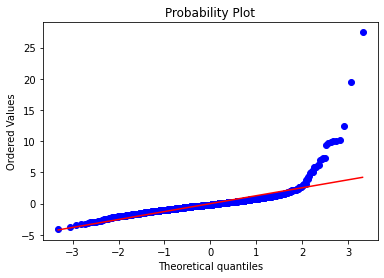

(1.0985309879216723, 0.10006239497118648)


In [77]:
#Linearity
from scipy.stats import probplot
import statsmodels.api as sm
probplot(model.resid,plot = plt)
plt.show()
print(sm.stats.diagnostic.linear_rainbow(model))
#Model fails the test of linearity accoring to the linear_rainbow test since its p-value is less than 0.05 and we 
#reject the null hypothesis.

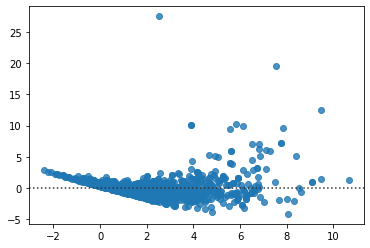

In [78]:
#Heteroskedasticity
test_stat,p_value,ftest,p_valftest = sm.stats.diagnostic.het_breuschpagan(model.resid,x_train)
p_value
#Model is heteroskedastic since p_value is less than 0.05
sns.residplot(model.fittedvalues,model.resid)
plt.show('Heteroskedastic pattern')
plt.show()
#We clearly can see a heteroskedastic pattern here.

In [79]:
#Multi-Collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
scores = []
d_1 = x.drop(['config_apartment','total_floors_log','bathrooms','longitude','latitude','area_log'],axis =1)

for i in range(len(d_1.columns)):
    scores.append(vif(d_1.values,i))
vif_summary = pd.DataFrame({'Features':d_1.columns,'VIF':scores})
vif_summary
#Though latitude and longitude show large multicollinearity, I believe that these features are important to determine price.

,Features,VIF
0,BHK,6.664737
1,no_of_parking,2.805992
2,flat_floor_no_log,4.795365
3,Possession_Status_received,7.317990
4,new_or_resale_Resale,6.170348
5,furnishing_Semi-Furnished,2.432955
6,furnishing_Unfurnished,3.258804
7,overlooking_other,2.394205
8,config_Studio,1.034127
9,config_other,1.043986


In [80]:
#Model after removing collinear variables
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split
#Data for modelling
model_data = pd.get_dummies(f_data,drop_first = True)

x_ = model_data[vif_summary['Features'].values]
y = model_data.price
x1 = sm.add_constant(x_)

x_train,x_test,y_train,y_test = train_test_split(x1,y,test_size = 0.2,random_state = 6)

model_pvif = OLS(y_train,x_train).fit()

print(model_pvif.summary())
#While we have seen a massive reduction in multicollinearity, our adjusted r2_score has also taken a hit. 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     95.59
Date:                Sun, 07 Feb 2021   Prob (F-statistic):          4.31e-175
Time:                        21:01:10   Log-Likelihood:                -3042.7
No. Observations:                1508   AIC:                             6111.
Df Residuals:                    1495   BIC:                             6180.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [81]:
metrics(y_train,model_pvif.predict(x_train),'OLS removing multicollinearity train')
metrics(y_test,model_pvif.predict(x_test),'OLS removing multicollinearity test')

OLS removing multicollinearity train RMSE is: 1.8198170852320583
OLS removing multicollinearity train r2_score is: 0.43414811260551933
OLS removing multicollinearity test RMSE is: 1.7606693181391981
OLS removing multicollinearity test r2_score is: 0.46629701105845855


('OLS removing multicollinearity test', 1.7606693181391981)

* Our train RMSE is much greater than the test RMSE. This means that the model has underfit.
* The difference between the test and train metrics have not reduced which tells me that our underfitting problem has not been solved.
* Probably regularization can be tried at this stage since the difference betweeen train and test scores is high.
* My hunch is that using ridge, lasso or elastic net which penalizes coefficients would do a better job here.
* We should also apply log transformation on the target variable and check if our model improves.

In [82]:
#Performing log transform on 'price' column of f_data to reduce heteroskedasticity
f_data['price'] = np.log(f_data['price'])

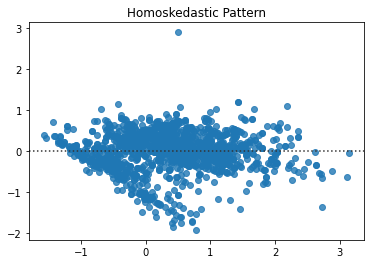

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     238.8
Date:                Sun, 07 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:01:10   Log-Likelihood:                -961.23
No. Observations:                1508   AIC:                             1960.
Df Residuals:                    1489   BIC:                             2062.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [83]:
#We could maybe try to apply log transformation on the target variable and keep all parameters to improve this.
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split
#Data for modelling
model_data = pd.get_dummies(f_data,drop_first = True)

x = model_data.drop('price',axis= 1)
y = model_data.price
x1 = sm.add_constant(x)

x_train,x_test,y_train,y_test = train_test_split(x1,y,test_size = 0.2,random_state = 6)

model = OLS(y_train,x_train).fit()

sns.residplot(model.fittedvalues,model.resid)
plt.title('Homoskedastic Pattern')
plt.show()
#As can be observed we have reduced the heteroskedastic nature of the model. Let us check the model summary
print(model.summary())
#Our model sees a massive jump in the r2_score. I think we must perform log transform on the target variable.

In [84]:
metrics(y_train,model.predict(x_train),model_name = 'OLS all params (log on target) train')
name,r_mse = metrics(y_test,model.predict(x_test),model_name = 'OLS all params (log on target) test')
best_model.setdefault(name,r_mse)
#Model is still overfitting but r2_score has increased.

OLS all params (log on target) train RMSE is: 0.45770911349952836
OLS all params (log on target) train r2_score is: 0.7427273499948872
OLS all params (log on target) test RMSE is: 0.474950638252763
OLS all params (log on target) test r2_score is: 0.7010775320196826


0.474950638252763

### Regularization

**Regularization Libraries**

In [85]:
from sklearn.linear_model import Ridge,Lasso,ElasticNet

In [86]:
#Function for fitting regularized models
def regularized_models(data,target,model_name = 'Ridge',model = Ridge(alpha = 1)):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import Ridge,Lasso,ElasticNet
    import pandas as pd
    import numpy as np
    
    #Function for calculating RMSE and r2score
    def metrics(y,ypred,model_name = 'Unknown'):
        from sklearn.metrics import mean_squared_error,r2_score
        RMSE = np.sqrt(mean_squared_error(y,ypred))
        r2score = r2_score(y,ypred)
        print("{} RMSE is: {}".format(model_name,RMSE))
        print("{} r2_score is: {}".format(model_name,r2score))
        return model_name,RMSE
    
    #Get dummies for data
    d = pd.get_dummies(data,drop_first = True)
    
    #Create x and y for seperating dependent and independent variables
    x = d.drop(target,axis = 1)
    y = d[target]
    
    #Split into train and test
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 1)
    m = model
    m.fit(x_train,y_train)
    
    #Printing metrics
    metrics(y_train,model.predict(x_train),model_name+' train')
    name,r_mse = metrics(y_test,model.predict(x_test),model_name+' test')
    return name,r_mse

In [87]:
#Function to find best parameters
def grid_search(model,x,y,params,cv = 5,verbose = 0,n_jobs = -1):
    from sklearn.model_selection import GridSearchCV
    grid = GridSearchCV(estimator = model,param_grid = params,scoring='r2',cv = cv,verbose = verbose,n_jobs = n_jobs)
    grid.fit(x,y)
    return grid.best_params_

###### Lasso

In [88]:
#Without hyperpararmeter tuning
name,r_mse = regularized_models(f_data,target = 'price',model_name = 'Lasso',model = Lasso(alpha = 1))
best_model.setdefault(name,r_mse)

Lasso train RMSE is: 0.8986221330970793
Lasso train r2_score is: 0.0
Lasso test RMSE is: 0.8843736877178564
Lasso test r2_score is: -0.0013189423627972818


0.8843736877178564

In [89]:
params = {'alpha':[0.001,0.005,0.05,0.01,0.1,1,1.5,2,5,10]}
l_b = grid_search(Lasso(),x_train,y_train,params = params)
l_b

{'alpha': 0.001}

In [90]:
name,r_mse = regularized_models(f_data,target = 'price',model_name = 'Lasso',model = Lasso(alpha = l_b['alpha']))
best_model.setdefault(name,r_mse)

Lasso train RMSE is: 0.46288899345812146
Lasso train r2_score is: 0.7346619785481535
Lasso test RMSE is: 0.45670246657287017
Lasso test r2_score is: 0.7329654100398346


0.8843736877178564

###### Ridge

In [91]:
#Without hyperparameter tuning
name,r_mse = regularized_models(f_data,target = 'price',model_name = 'ridge')
best_model.setdefault(name,r_mse)

ridge train RMSE is: 0.4625275235836463
ridge train r2_score is: 0.7350762215046871
ridge test RMSE is: 0.457719345412707
ridge test r2_score is: 0.7317749451440947


0.457719345412707

In [92]:
params = {'alpha':[0.001,0.005,0.05,0.01,0.1,1,1.5,2,5,10]}
r_b = grid_search(Ridge(),x_train,y_train,params = params)
r_b

{'alpha': 0.05}

In [93]:
name,r_mse = regularized_models(f_data,target = 'price',model_name = 'ridge',model = Ridge(alpha = r_b['alpha']))
best_model.setdefault(name,r_mse)

ridge train RMSE is: 0.46224781006667676
ridge train r2_score is: 0.7353965499228337
ridge test RMSE is: 0.4559821156726801
ridge test r2_score is: 0.733807126119579


0.457719345412707

###### ElasticNet

In [94]:
#Without hyperparameter tuning
regularized_models(f_data,target = 'price',model_name = 'ElasticNet',model = ElasticNet(alpha = 1,l1_ratio = 0.5))

ElasticNet train RMSE is: 0.8467714955258143
ElasticNet train r2_score is: 0.11207100464039299
ElasticNet test RMSE is: 0.8378355129359931
ElasticNet test r2_score is: 0.10129256272605214


('ElasticNet test', 0.8378355129359931)

In [95]:
params_e = {'alpha':[0.001,0.005,0.05,0.01,0.1,1,1.5,2,5,10],'l1_ratio':[0.001,0.005,0.05,0.01,0.1,0.5,1,1.2,1.6]}
b_e = grid_search(ElasticNet(),x_train,y_train,params = params_e)
b_e

{'alpha': 0.001, 'l1_ratio': 1}

In [96]:
name,r_mse = regularized_models(model_data,target = 'price',model_name = 'ElasticNet',model = ElasticNet(alpha = b_e['alpha'],l1_ratio = b_e['l1_ratio']))
best_model.setdefault(name,r_mse)

ElasticNet train RMSE is: 0.46288899345812146
ElasticNet train r2_score is: 0.7346619785481535
ElasticNet test RMSE is: 0.45670246657287017
ElasticNet test r2_score is: 0.7329654100398346


0.45670246657287017

## Trying non-linear models on our dataset

In [ ]:
def non_linear_models(data,model):
    from sklearn.model_selection import train_test_split
    model = model
    x = data.drop('price',axis = 1)
    y = data.price
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 6)
    model.fit(x_train,y_train)
    
    def metrics(y,ypred,model_name = 'Unknown'):
        from sklearn.metrics import mean_squared_error,r2_score
        RMSE = np.sqrt(mean_squared_error(y,ypred))
        r2score = r2_score(y,ypred)
        print("{} RMSE is: {}".format(model_name,RMSE))
        print("{} r2_score is: {}".format(model_name,r2score))
        return model_name,r2score
    
    metrics(y_train,model.predict(x_train),str(model)+' train')
    name,r_mse = metrics(y_test,model.predict(x_test),str(model)+' test')
    return name,r_mse
    

###### DecisionTree

In [98]:
#Trying RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
non_linear_models(model_data,DecisionTreeRegressor())
#Decision Tree known for its infamous nature of overfitting has shown expected results here. 
# Test r2_score is way lower than train r2_score.

DecisionTreeRegressor() train RMSE is: 0.000519373997304771
DecisionTreeRegressor() train r2_score is: 0.9999996687354935
DecisionTreeRegressor() test RMSE is: 0.3628789891720816
DecisionTreeRegressor() test r2_score is: 0.8255040891108938


('DecisionTreeRegressor() test', 0.3628789891720816)

In [99]:
#We will use our grid search function to find best parameters for randomforest.
params_dt = {
            'criterion':['mse','mae'],
            'min_samples_split':[2,5,8,10,20,40,100],
            'min_samples_leaf':[1,5,10,15,25,50,100],
            
                 }

In [100]:
#Creating train and test split for grid search
x = model_data.drop('price',axis = 1)
y = model_data.price
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 6)
best_param_dt = grid_search(DecisionTreeRegressor(),x = x_train, y = y_train,params = params_dt,cv = 5,verbose = 1)
best_param_dt

Fitting 5 folds for each of 98 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:    3.9s finished


{'criterion': 'mae', 'min_samples_leaf': 1, 'min_samples_split': 10}

In [101]:
name,r_mse = non_linear_models(model_data,DecisionTreeRegressor(criterion = best_param_dt['criterion'],
                                                   min_samples_leaf = best_param_dt['min_samples_leaf'],
                                                   min_samples_split = best_param_dt['min_samples_split']))
best_model.setdefault(name,r_mse)
#The tuned parameters seem to reduce the amount of overfitting. 
#But still there is a big gap between train and test score.

DecisionTreeRegressor(criterion='mae', min_samples_split=10) train RMSE is: 0.2017125573734731
DecisionTreeRegressor(criterion='mae', min_samples_split=10) train r2_score is: 0.950033334107078
DecisionTreeRegressor(criterion='mae', min_samples_split=10) test RMSE is: 0.37840888551068713
DecisionTreeRegressor(criterion='mae', min_samples_split=10) test r2_score is: 0.8102489187760407


0.37840888551068713

###### RandomForest

In [102]:
#Trying RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
non_linear_models(model_data,RandomForestRegressor())

#RandomForestRegressor is overfitting the data since we are getting a very high r2_score.
#We can try hyperparameter tuning to try to reduce this problem.

RandomForestRegressor() train RMSE is: 0.11325022924733046
RandomForestRegressor() train r2_score is: 0.9842495603873452
RandomForestRegressor() test RMSE is: 0.2948357696908346
RandomForestRegressor() test r2_score is: 0.8848080976340756


('RandomForestRegressor() test', 0.2948357696908346)

In [103]:
#We will use our grid search function to find best parameters for randomforest.


params_rf = {'n_estimators': [200,225,250],
            'criterion':['mse'],
            'min_samples_split':[1,2,3,4],
            'min_samples_leaf':[1,2,3],
            'bootstrap':[True]
                 }

In [104]:
#Creating train and test split for grid search
x = model_data.drop('price',axis = 1)
y = model_data.price
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 6)
best_param_rf = grid_search(RandomForestRegressor(),x = x_train, y = y_train,params = params_rf,cv = 5,verbose = 1)
best_param_rf

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   40.2s finished


{'bootstrap': True,
 'criterion': 'mse',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [105]:
# best_param_rf = {'bootstrap': True,
#  'criterion': 'mse',
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'n_estimators': 225}

In [106]:
#Trying RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
name,r_mse = non_linear_models(model_data,RandomForestRegressor(bootstrap = best_param_rf['bootstrap'],criterion = best_param_rf['criterion'],min_samples_leaf = best_param_rf['min_samples_leaf'],min_samples_split = best_param_rf['min_samples_split'],n_estimators = best_param_rf['n_estimators']))
best_model.setdefault(name,r_mse)
#RandomForestRegressor is overfitting the data since we are getting a very high r2_score.
#We can try hyperparameter tuning to try to reduce this problem.

RandomForestRegressor(n_estimators=200) train RMSE is: 0.11137863702836989
RandomForestRegressor(n_estimators=200) train r2_score is: 0.9847658475142457
RandomForestRegressor(n_estimators=200) test RMSE is: 0.2940734366087486
RandomForestRegressor(n_estimators=200) test r2_score is: 0.8854030123589101


0.2940734366087486

In [107]:
#Apply cross validation on random forest to see if there is any change. (Currently the model is overfitting.)

In [108]:
#Creating a function for cross val score.
def cross_val(estimator,X,y,cv,verbose = 0):
    from sklearn.model_selection import cross_val_score
    s = cross_val_score(estimator = estimator,X = X,y = y,cv = cv,verbose = verbose)
    print("Min Cross_val_score:",min(s))
    print("Max Cross_val_score:",max(s))
    print("Average Cross_val_score:",np.mean(s))

In [109]:
cross_val(estimator = RandomForestRegressor(bootstrap = True,criterion = 'mse',min_samples_leaf = 1,min_samples_split = 2,n_estimators = 225),X = x_train,y = y_train,cv = 5)
#On the train data when we apply cross validation, we get below mean score. 
#This is inline with the test r2_score that we are getting above.

Min Cross_val_score: 0.8363608020356883
Max Cross_val_score: 0.9066812242248141
Average Cross_val_score: 0.8733932121884106


### Adaboost (Adaptive Boosting):

* Adaboost introduces the concept of weights into decision trees and random forests and is moving towards deep learning approaches.
* Adaboost combines a lot of week learners to make classifications.
* Some learners(tree stumps) get more say than others.
* Each stump is made by taking the previous stumps mistakes into account.
* At the start weights = (1/N (number of rows))
* Classification is checked for each feature and correct and incorrect classifications are obtained.
* Gini Index determines which stump will come first. Each stump is made of one feature. Lower gini index means feature will be the first stump.
* Total error = Sum of weights of correctly classified samples. (0-1). Lower is better.
* Amount of say (alpha):
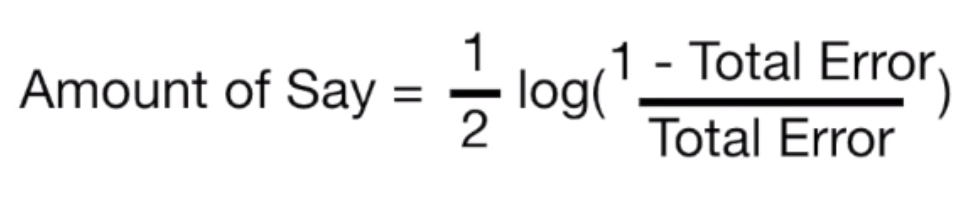

* **In below diagram negative means it will reverse the classification output to make the incorrect classification correct. If error is 0.5, amount of say is 0.**

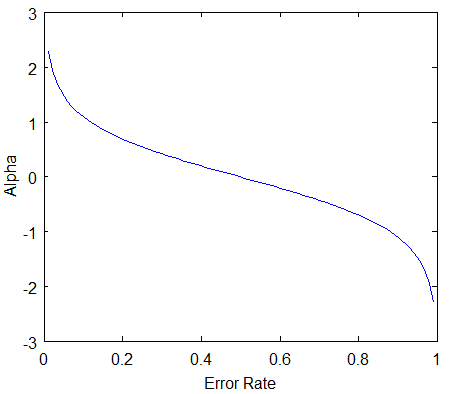

* The new sample weight = old sample weight * e^amount of say.

* Next we will decrease the sample weights = sample weight * e^-amount of say. This is done to improve performance.
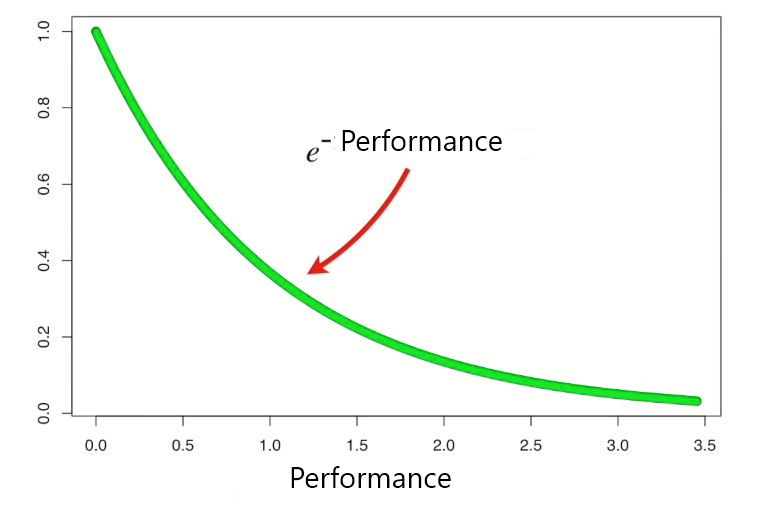
* After we have found the sample weight we will make this the new weights for the correct and incorrect classifications and normalize them. These weights will now be used for the next stump. To create a new collection of samples and get rid of the old samples.

In [110]:
from sklearn.ensemble import AdaBoostRegressor
non_linear_models(model_data,AdaBoostRegressor())
#Adaboost model without tuning seems to have reduced the gap between the train and the test RMSE by 0.4 basis pts.

AdaBoostRegressor() train RMSE is: 0.46363027500376647
AdaBoostRegressor() train r2_score is: 0.7360278707574037
AdaBoostRegressor() test RMSE is: 0.485148440415782
AdaBoostRegressor() test r2_score is: 0.6881032228304153


('AdaBoostRegressor() test', 0.485148440415782)

In [112]:
dt = DecisionTreeRegressor(criterion = best_param_dt['criterion'],
                                                   min_samples_leaf = best_param_dt['min_samples_leaf'],
                                                   min_samples_split = best_param_dt['min_samples_split'])

# rf = RandomForestRegressor(bootstrap = best_param_rf['bootstrap'],
#                            criterion = best_param_rf['criterion'],
#                            min_samples_leaf = best_param_rf['min_samples_leaf'],
#                            min_samples_split = best_param_rf['min_samples_split'],
#                            n_estimators = best_param_rf['n_estimators'])

params_abr = {
    'base_estimator':[dt],
    'n_estimators': [50,100,150],
    'learning_rate':[0.5,1.0,1.5],
}

best_param_abr = grid_search(model = AdaBoostRegressor(),x = x_train,y = y_train,params = params_abr,cv = 5,verbose = 2)
best_param_abr

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.6min finished


{'base_estimator': DecisionTreeRegressor(criterion='mae', min_samples_split=10),
 'learning_rate': 1.5,
 'n_estimators': 100}

In [113]:
name,r_mse = non_linear_models(model_data,AdaBoostRegressor(base_estimator = best_param_abr['base_estimator'],
                                               n_estimators = best_param_abr['n_estimators'],
                                               learning_rate = best_param_abr['learning_rate']))
best_model.setdefault(name,r_mse)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae',
                                                       min_samples_split=10),
                  learning_rate=1.5, n_estimators=100) train RMSE is: 0.06877300878397496
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae',
                                                       min_samples_split=10),
                  learning_rate=1.5, n_estimators=100) train r2_score is: 0.9941916797985202
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae',
                                                       min_samples_split=10),
                  learning_rate=1.5, n_estimators=100) test RMSE is: 0.2540912792610998
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae',
                                                       min_samples_split=10),
                  learning_rate=1.5, n_estimators=100) test r2_score is: 0.9144458408050017


0.2540912792610998

###### Since not all classifiers are considered equal and weights are playing a significant role, we have been able to increase our test score to 90% in this case. However I still feel the model is overfitting because our train score is 99% and testRMSE is grater than train RMSE. It took around 2.5 hours on my system to run the grid search!!!!

In [114]:
#Applying cross validation score
best_abr = AdaBoostRegressor(base_estimator = best_param_abr['base_estimator'],
                                               n_estimators = best_param_abr['n_estimators'],
                                               learning_rate = best_param_abr['learning_rate'])
cross_val(estimator = best_abr,X = x_train,y = y_train,cv = 5,verbose = 2)

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   5.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV] ................................................. , total=   6.0s
[CV]  ................................................................
[CV] ................................................. , total=   5.5s
[CV]  ................................................................
[CV] ................................................. , total=   6.1s
[CV]  ................................................................
[CV] ................................................. , total=   6.1s
Min Cross_val_score: 0.8480289049584374
Max Cross_val_score: 0.9282612263118059
Average Cross_val_score: 0.8959836407032074


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.5s finished


In [115]:
best_abr.fit(x_train,y_train)
train_gbr_pred = best_abr.predict(x_train)
test_gbr_pred = best_abr.predict(x_test)
metrics(y_train,train_gbr_pred,model_name = 'adaboost train')
metrics(y_test,test_gbr_pred,model_name = 'adaboost test')

adaboost train RMSE is: 0.06961334882484355
adaboost train r2_score is: 0.9940488684117272
adaboost test RMSE is: 0.25445391670132994
adaboost test r2_score is: 0.9142014618493531


('adaboost test', 0.25445391670132994)

In [116]:
#import pickle
filename = 'Saved Models/adbmodel.model'
#pickle.dump(obj = best_xgb,file = open('Saved Models/'+filename,'wb'))
import joblib
#save model
joblib.dump(best_abr, filename) 

['Saved Models/adbmodel.model']

###### Adaboost seems to be overfitting on my dataset at this instance. I would look at gradient boosting next. Where along with weights we are also reducing the error using gradient descent.

### GradientBoosting

In [117]:
from sklearn.ensemble import GradientBoostingRegressor
non_linear_models(data = model_data,model = GradientBoostingRegressor())
#Without applying any kind of parameter tuning, GradientBoosting is performing very well.

GradientBoostingRegressor() train RMSE is: 0.2687676694813941
GradientBoostingRegressor() train r2_score is: 0.9112908227459205
GradientBoostingRegressor() test RMSE is: 0.3073967578589523
GradientBoostingRegressor() test r2_score is: 0.8747838999358515


('GradientBoostingRegressor() test', 0.3073967578589523)

In [118]:
params_gbr = {
        'learning_rate': [0.05,0.1,0.5],
        'n_estimators': [200,250,300],
        'min_samples_leaf': [6,8,10],
        'min_samples_split':[50,100,150],
        'max_depth':[7,8,9],
        'subsample':[0.1,0.5,0.8,1]
}

In [120]:
# gbr_best = grid_search(model = GradientBoostingRegressor(),
#             x = x_train,
#             y = y_train,
#             params = params_gbr,
#             cv = 5,
#             verbose = 3,
#             n_jobs = 4
#            )
# gbr_best

In [121]:
# gbr_best = {'learning_rate': 0.1,
#  'max_depth': 8,
#  'min_samples_leaf': 8,
#  'min_samples_split': 100,
#  'n_estimators': 300,
#  'subsample': 0.8}

In [122]:
non_linear_models(data = model_data,
                  model = GradientBoostingRegressor(
                      learning_rate = gbr_best['learning_rate'],
                      n_estimators = gbr_best['n_estimators'],
                      min_samples_leaf = gbr_best['min_samples_leaf'],
                      min_samples_split = gbr_best['min_samples_split'],
                      max_depth = gbr_best['max_depth'],
                      subsample = gbr_best['subsample']
                  ))


NameError: name 'gbr_best' is not defined

###### There is a slight reduction in the train score which tells me that gradient boosting has introduced some bias and reduced overfitting.

In [123]:
gbr_model = GradientBoostingRegressor(
                      learning_rate = gbr_best['learning_rate'],
                      n_estimators = gbr_best['n_estimators'],
                      min_samples_leaf = gbr_best['min_samples_leaf'],
                      min_samples_split = gbr_best['min_samples_split'],
                      max_depth = gbr_best['max_depth'],
                      subsample = gbr_best['subsample']
                  )
gbr_model.fit(x_train,y_train)
train_pred = gbr_model.predict(x_train)
test_pred = gbr_model.predict(x_test)

NameError: name 'gbr_best' is not defined

In [124]:
name,r_mse = metrics(y = y_test,ypred = test_pred,model_name = 'GradientBoostRegressor test')
best_model.setdefault(name,r_mse)

NameError: name 'test_pred' is not defined

In [125]:
#Apply cross_val_score on entire dataset.
cross_val(estimator = gbr_model,X = x_train,y = y_train,cv = 15,verbose = 1)

NameError: name 'gbr_model' is not defined

In [126]:
#import pickle
filename = 'Saved Models/gbrmodel.model'
#pickle.dump(obj = best_xgb,file = open('Saved Models/'+filename,'wb'))
import joblib
#save model
joblib.dump(gbr_model, filename) 

NameError: name 'gbr_model' is not defined

### XGBoost

In [127]:
import xgboost as xgb
from xgboost import XGBRegressor

In [128]:
model_data.sample(5)

,bathrooms,price,BHK,no_of_parking,longitude,latitude,area_log,flat_floor_no_log,total_floors_log,Possession_Status_received,new_or_resale_Resale,furnishing_Semi-Furnished,furnishing_Unfurnished,overlooking_other,config_Studio,config_apartment,config_other,parking_type_Open,parking_type_both
603,3.0,0.854415,3,1,72.864084,19.210381,6.907755,2.995732,3.295837,1,1,1,0,1,0,1,0,1,0
801,3.0,0.955511,3,1,72.918533,19.141188,7.029088,3.218876,3.688879,0,0,0,1,1,0,1,0,0,0
418,2.0,0.095310,2,0,72.935519,19.117259,6.364751,2.944439,3.135494,0,0,0,1,0,0,1,0,1,0
173,2.0,-0.798508,2,1,72.847871,19.009539,6.345636,1.945910,3.135494,0,0,1,0,1,0,1,0,1,0
1591,3.0,1.880991,3,2,72.907966,19.060807,7.056175,3.295837,3.663562,0,0,0,1,1,0,1,0,0,0


In [129]:
reg_xgb = XGBRegressor()
model_xgb = reg_xgb.fit(x_train,y_train,verbose = True,early_stopping_rounds = 20,eval_set = [(x_test,y_test)])

[0]	validation_0-rmse:0.68335
[1]	validation_0-rmse:0.54944
[2]	validation_0-rmse:0.45383
[3]	validation_0-rmse:0.39902
[4]	validation_0-rmse:0.36963
[5]	validation_0-rmse:0.35233
[6]	validation_0-rmse:0.34157
[7]	validation_0-rmse:0.32969
[8]	validation_0-rmse:0.32315
[9]	validation_0-rmse:0.32059
[10]	validation_0-rmse:0.31075
[11]	validation_0-rmse:0.30577
[12]	validation_0-rmse:0.30339
[13]	validation_0-rmse:0.29750
[14]	validation_0-rmse:0.29567
[15]	validation_0-rmse:0.28975
[16]	validation_0-rmse:0.28932
[17]	validation_0-rmse:0.28734
[18]	validation_0-rmse:0.28697
[19]	validation_0-rmse:0.28593
[20]	validation_0-rmse:0.28555
[21]	validation_0-rmse:0.28489
[22]	validation_0-rmse:0.28414
[23]	validation_0-rmse:0.28386
[24]	validation_0-rmse:0.28316
[25]	validation_0-rmse:0.28346
[26]	validation_0-rmse:0.28344
[27]	validation_0-rmse:0.28374
[28]	validation_0-rmse:0.28371
[29]	validation_0-rmse:0.28355
[30]	validation_0-rmse:0.28334
[31]	validation_0-rmse:0.28212
[32]	validation_0-

In [130]:
train_ypred = model_xgb.predict(x_train)
metrics(y_train,train_ypred,model_name = 'train_xgbRegressor')

test_ypred = model_xgb.predict(x_test)
metrics(y_test,test_ypred,model_name = 'test_xgbRegressor')

train_xgbRegressor RMSE is: 0.05992968421738005
train_xgbRegressor r2_score is: 0.9955893918162967
test_xgbRegressor RMSE is: 0.27102907353921635
test_xgbRegressor r2_score is: 0.9026595456422233


('test_xgbRegressor', 0.27102907353921635)

While the model is still overfitting. But the gap between train and test scores has reduced from gradientboost. Trying gridsearch to see if there is any improvement.

In [134]:
xgb_params = {
    'max_depth':[4,5,6,7,8],
    'n_estimators': list(range(0,300,50)),
    'learning_rate': [0.07,0.1,0.5],
    'colsample_bytree': [0.7,0.8,0.9,1]
}

In [ ]:
xgb_best = grid_search(model = XGBRegressor(),x = x_train,y = y_train,params = xgb_params,cv = 5,verbose = 1,n_jobs = 6)
xgb_best

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   19.7s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   46.3s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  2.2min


In [ ]:
# xgb_best = {'colsample_bytree': 0.9,
#  'learning_rate': 0.1,
#  'max_depth': 5,
#  'n_estimators': 250,
#  'subsample': 0.8}

In [ ]:
best_xgb = XGBRegressor(max_depth = xgb_best['max_depth'],
                        n_estimators = xgb_best['n_estimators'],
                        learning_rate = xgb_best['learning_rate'],
                        colsample_bytree = xgb_best['colsample_bytree'],
                       random_state = 42)
model_best = best_xgb.fit(x_train,y_train,verbose = False,early_stopping_rounds = 20,eval_set = [(x_test,y_test)])

In [ ]:
train_ypred1 = model_best.predict(x_train)
metrics(y_train,train_ypred1,model_name = 'train_xgbRegressor')

test_ypred1 = model_best.predict(x_test)
name,r_mse = metrics(y_test,test_ypred1,model_name = 'test_xgbRegressor')
best_model.setdefault(name,r_mse)

In [ ]:
cross_val(estimator = best_xgb,X = x_train,y = y_train,cv = 5,verbose = 3)

### All models test rmse

In [ ]:
best_model

###### Saving the model

In [ ]:
#import pickle
filename = 'Saved Models/xgbmodel.model'
#pickle.dump(obj = best_xgb,file = open('Saved Models/'+filename,'wb'))
import joblib
#save model
joblib.dump(model_best, filename) 

#load saved model
model = joblib.load(filename)

###### Making predictions

In [ ]:
# import pickle
# model = pickle.load(open('C:/Users/tejas/Desktop/real-estate-price-prediction-end-to-end-project-with-deployment/Jupyter Notebooks/Saved Models/xgbmodel.pickle','rb'))

###### Making predictions

In [ ]:
# def lat_long_gen(location):
#     import geopy
#     from geopy.geocoders import Nominatim
#     locator = Nominatim(user_agent="myGeocoder")
#     locating = locator.geocode(location)
#     return locating.longitude,locating.latitude    

In [ ]:
# longitude,latitude = lat_long_gen('Colaba')

In [ ]:
# bathrooms = 3 
# BHK = 3#
# no_of_parking = 1
# area = 1400
# flat_floor_no = 7
# total_floors = 16
# Possession_Status_received = 1
# new_or_resale_Resale = 1
# furnishing_Semi_Furnished,furnishing_Unfurnished = [0,1]
# overlooking_other = 1
# config_Studio,config_apartment,config_other = [0,1,0]
# parking_type_open,parking_type_both = [1,0]

In [ ]:
# params = [bathrooms,BHK, no_of_parking, longitude, latitude,
#        np.log(area), np.log(flat_floor_no), np.log(total_floors),
#        Possession_Status_received, new_or_resale_Resale,
#        furnishing_Semi_Furnished, furnishing_Unfurnished,
#        overlooking_other, config_Studio, config_apartment,
#        config_other, parking_type_open, parking_type_both]

# col_names = ['bathrooms', 'BHK', 'no_of_parking', 'longitude', 'latitude',
#        'area_log', 'flat_floor_no_log', 'total_floors_log',
#        'Possession_Status_received', 'new_or_resale_Resale',
#        'furnishing_Semi-Furnished', 'furnishing_Unfurnished',
#        'overlooking_other', 'config_Studio', 'config_apartment',
#        'config_other', 'parking_type_Open', 'parking_type_both']

# data_to_predict = pd.DataFrame(params,index = col_names).T
# data_to_predict